This notebook can be run in two ways:
- Run all cells from beginning to end. However, this is a time-consuming process that will take about 10hrs. Note that the maximal runtime of a colab notebook is 12hrs. If a section is time-consuming, then the estimated time will be reported at the beginning of the section. 

- Run the different sections independently. The necessary files are provided in the output folder and are saved as pickle at the end of each section. 

If not downloaded to the your machine all the new generated pickles will be lost once the colab session is terminated. 
If you want to download a file to your machine you can use:
```python
from google.colab import files
files.download(str(output_path / 'file_name.p'))
```

# 1. Setting up the enviroment

In [ ]:
# Cloning the git repo with the data structure and complentary files
# Note: to run the code in this notebook, you will have to accept that the 
# code was not developed by google.
!git clone https://github.com/Mind-the-Pineapple/into-the-multiverse/

In [ ]:
# Install necessary python dependencies
! pip install -r into-the-multiverse/requirements.txt

Note: Remember to restart the runtime by clicking on the button above to have the same version of matplotlib, mpl_toolkits, numpy as specified in the requirement.txt file.

## Download the Data

All the data used for this project is [public availiable](https://figshare.com/articles/Data_for_Conservative_and_disruptive_modes_of_adolescent_change_in_human_brain_functional_connectivity_/11551602) and consists of 520 scans from 298 healthy [Váša et. al, 2020](https://www.pnas.org/content/117/6/3248) individuals (age 14-26, mean age = 19.24, see  for
details)

In [ ]:
#!wget -O into-the-multiverse/data/age/nspn.fmri.main.RData https://ndownloader.figshare.com/files/20958708
!wget -O data/age/nspn.fmri.main.RData https://ndownloader.figshare.com/files/20958708

In [ ]:
#!wget -O into-the-multiverse/data/age/nspn.fmri.gsr.RData https://ndownloader.figshare.com/files/20958699
!wget -O data/age/nspn.fmri.gsr.RData https://ndownloader.figshare.com/files/20958699

In [ ]:
#!wget -O into-the-multiverse/data/age/nspn.fmri.lowmot.RData https://ndownloader.figshare.com/files/20958702
!wget -O data/age/nspn.fmri.lowmot.RData https://ndownloader.figshare.com/files/20958702

In [ ]:
#!wget -O into-the-multiverse/data/age/nspn.fmri.general.vars.RData https://ndownloader.figshare.com/files/20819796
!wget -O data/age/nspn.fmri.general.vars.RData https://ndownloader.figshare.com/files/20819796

## Define key variables

As mentioned this notebook was written so that every section could be run separately if needed. But in order to make this work, this section ([Define key variables](https://colab.research.google.com/drive/1fdEMsbZtQiTAwioeSn-JMLsJqcHqDoxj?authuser=2#)) needs to run and the variables that are going to be required saved into memory.

In [1]:
# Add the into-the-multiverse folder to the Python path. This allows the helperfunction
# to be used

#import sys
#sys.path.insert(1, 'into-the-multiverse')

# To run LOCALLY
import os
os.chdir('/Users/jessica/Code/into-the-multiverse-revised')

In [2]:
import pickle
import random

import pyreadr 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colorbar
import bct
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from helperfunctions import gateway_coef_sign, analysis_space
import warnings
warnings.filterwarnings("ignore")

In [3]:
from pathlib import Path

def get_variables_of_interest():
  # Set the random seed
  #np.random.seed(2)
  rng = np.random.default_rng(2)
  random.seed(2)

  # Define paths - REMOTE
  #PROJECT_ROOT = Path.cwd()
  #data_path = PROJECT_ROOT / 'into-the-multiverse' /'data' / 'age'
  #output_path = PROJECT_ROOT / 'into-the-multiverse' / 'output'/ 'age'

  # Define paths - LOCALLY
  PROJECT_ROOT = Path.cwd()
  data_path = PROJECT_ROOT / 'data' / 'age'
  output_path = PROJECT_ROOT / 'output' / 'age'

  # Load data
  data1 = pyreadr.read_r(str(data_path / 'nspn.fmri.main.RData'))
  data3 = pyreadr.read_r(str(data_path / 'nspn.fmri.lowmot.RData'))
  genVar = pyreadr.read_r(str(data_path / 'nspn.fmri.general.vars.RData'))
  data2 = pyreadr.read_r(str(data_path / 'nspn.fmri.gsr.RData'))

  DataNames=['nspn.fmri.main.RData','nspn.fmri.gsr.RData','nspn.fmri.lowmot.RData']

  #Dictionary of 16 graph theory measures taken from the Brain Connectivity Toolbox
  BCT_models = {
    'degree': bct.degrees_und,
    'strength': bct.strengths_und,
    'betweennness centrality': bct.betweenness_bin,
    'clustering (bin.)': bct.clustering_coef_bu,
    'clustering (wei.)': bct.clustering_coef_wu,
    'eigenvector centrality': bct.eigenvector_centrality_und,
    'sugraph centrality': bct.subgraph_centrality,
    'local efficiency' : bct.efficiency_bin,
    'modularity (louvain)': bct.modularity_louvain_und,
    'modularity (probtune)': bct.modularity_probtune_und_sign,
    'participation coefficient': bct.participation_coef,
    'module degree z-score': bct.module_degree_zscore,
    'pagerank centrality': bct.pagerank_centrality,
    'diversity coefficient': bct.diversity_coef_sign,
    'gateway degree': gateway_coef_sign,
    'k-core centrality': bct.kcoreness_centrality_bu,
}
  #Get info about brain regions and find Yeo network IDs; useful later on for 
  # graph metrics that need community labels.
  KeptIDs = np.asarray(genVar['hcp.keep.id'])
  YeoIDs = np.asarray(genVar['yeo.id.subc'])
  KeptYeoIDs = YeoIDs[KeptIDs-1][:,0,0]

  # Define some images properites
  n_regions = 346
  subject_array = 520

  #Get motion regression functional connectivity data and reshape into 
  # region x region x subject array
  FC = np.asarray(data1['fc.main'])
  MainNoNan = np.nan_to_num(FC,copy=True,nan=1.0)
  MainNoNanReshape = np.reshape(MainNoNan, [n_regions,n_regions,subject_array],
                              order='F')

  #Get global signal regression functional connectivity data and reshape into
  # region x region x subject array
  FC=np.asarray(data2['fc.gsr'])
  GSRNoNan = np.nan_to_num(FC,copy=True,nan=1.0)
  GSRNoNanReshape = np.reshape(GSRNoNan, [n_regions,n_regions,subject_array],
                            order='F')

  #Read in subject IDs and age
  IDMain=np.asarray(data1['id.main'])
  ages=np.asarray(data1['age.main'])

  #Find unique subject IDs and index of first instance and find FC data 
  # corresponding to these indices
  IDs,IDIndexUnique = np.unique(IDMain,return_index=True)
  MainNoNanReshapeUnique = MainNoNanReshape[:,:,IDIndexUnique]
  GSRNoNanReshapeUnique = GSRNoNanReshape[:,:,IDIndexUnique]
  AgesUnique = ages[IDIndexUnique]

  # Number of randomly selected subjects to be used to define the low-dimensional 
  # space then split FC data and age data into two: 50 for defining space and 
  #remaining 248 for subsequent prediction
  SpaceDefineN = 50
  RandomIndexes = rng.choice(IDs.shape[0], size=IDs.shape[0], replace=False)
  MainNoNanModelSpace = MainNoNanReshapeUnique[:,:,RandomIndexes[0:SpaceDefineN]]
  MainNoNanPrediction = MainNoNanReshapeUnique[:,:,RandomIndexes[SpaceDefineN:]]
  GSRNoNanModelSpace = GSRNoNanReshapeUnique[:,:,RandomIndexes[0:SpaceDefineN]]
  GSRNoNanPrediction = GSRNoNanReshapeUnique[:,:,RandomIndexes[SpaceDefineN:]]
  AgesModelSpace = AgesUnique[RandomIndexes[0:SpaceDefineN]]
  AgesPrediction = AgesUnique[RandomIndexes[SpaceDefineN:]]
  IDsModelSpace = IDs[RandomIndexes[0:SpaceDefineN]] 
  IDsPrediction = IDs[RandomIndexes[SpaceDefineN:]]
  return output_path, BCT_models, KeptYeoIDs, ages, AgesPrediction, \
         MainNoNanPrediction, GSRNoNanPrediction, MainNoNanModelSpace, \
         GSRNoNanModelSpace, n_regions, subject_array

In [4]:
output_path, BCT_models, KeptYeoIDs, Ages, AgesPrediction, \
         MainNoNanPrediction, GSRNoNanPrediction, MainNoNanModelSpace, \
         GSRNoNanModelSpace, n_regions, subject_array = \
         get_variables_of_interest()

Note: Some times running the cell above throws the following error:
```
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte
```
If this error shows up, restart the kernel and re-run all cells on this section

# 2. Run the different analysis to bild the space

This section will perform the exhaustive evaluation of all 544 (2 different analysis, 17 sparsity thresholds and 16 nodal graph theoretical
metrics) analysis approaches. 

In [ ]:
BCT_Run = {}
Sparsities_Run= {}
Data_Run = {}
GroupSummary = {}

thresholds = [0.4,0.3,0.25,0.2,0.175,0.150,0.125,0.1,0.09,0.08,
              0.07,0.06,0.05,0.04,0.03,0.02,0.01]
preprocessings = ['MRS', 'GRS']

n_thr = len(thresholds)
n_pre = len(preprocessings)
n_BCT = len(BCT_models.keys())
Results = np.zeros(((n_thr * n_pre * n_BCT), n_regions))
ResultsIndVar = np.zeros(((n_thr * n_pre * n_BCT), 1225))
count=0
with tqdm(range(n_thr * n_pre * n_BCT)) as pbar:
  for pre_idx, DataPreproc in enumerate(preprocessings): # data preprocessing
    if DataPreproc == 'MRS':
        TempData = MainNoNanModelSpace
        TotalSubjects = TempData.shape[2]
    elif DataPreproc == 'GRS':
        TempData = GSRNoNanModelSpace
        TotalSubjects = TempData.shape[2]

    for thr_idx, TempThreshold in enumerate(thresholds): # FC threshold level
        for BCT_Num in BCT_models.keys(): # Graph theory measure
            TempResults = np.zeros((TotalSubjects,n_regions))
            for SubNum in range(TotalSubjects):
                x = bct.threshold_proportional(TempData[:,:,SubNum],
                                               TempThreshold, copy=True)
                ss = analysis_space(BCT_Num, BCT_models, x, KeptYeoIDs)
                #For each subject for each approach keep the 346 regional values.        
                TempResults[SubNum, :] = ss 

            BCT_Run[count] = BCT_Num;
            Sparsities_Run[count] = TempThreshold
            Data_Run[count] = DataPreproc
            GroupSummary[count] ='Mean'
            # Build an array of similarities between subjects for each
            # analysis approach 
            cos_sim = cosine_similarity(TempResults, TempResults)        
            Results[count, :] = np.mean(TempResults, axis=0)
            ResultsIndVar[count, :] = cos_sim[np.triu_indices(TotalSubjects, k=1)].T 
            count += 1
            pbar.update(1)                        
                     
ModelsResults={"Results": Results,
               "ResultsIndVar": ResultsIndVar,
               "BCT": BCT_Run,
               "Sparsities": Sparsities_Run, 
               "Data": Data_Run, 
               "SummaryStat": GroupSummary}
            
pickle.dump( ModelsResults, open(str(output_path / "ModelsResults.p"), "wb" ) )

# 3. Building and analysing the low-dimensional space

## Different embeddings

This section will use five different embedding algorithms to produce a low-dimension space that then be used for the active learning. 

In [ ]:
from sklearn import manifold, datasets
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from functools import partial
from time import time
import pickle

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import phate
from sklearn.decomposition import PCA

In [ ]:
# Load the previous results
ModelResults = pickle.load(open(str(output_path / "ModelsResults.p"), "rb" ) )
Results = ModelResults['ResultsIndVar']
BCT_Run = ModelResults['BCT']
Sparsities_Run = ModelResults['Sparsities']
Data_Run = ModelResults['Data']
preprocessings = ['MRS', 'GRS']

In [ ]:
#Scale the data prior to dimensionality reduction
scaler = StandardScaler()
X = scaler.fit_transform(Results.T)
X = X.T
n_neighbors = 20
n_components = 2 #number of components requested. In this case for a 2D space.

#Define different dimensionality reduction techniques 
methods = OrderedDict()
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='dense')
methods['LLE'] = LLE(method='standard', random_state=0)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors, random_state=0)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)
methods['UMAP'] = UMAP(random_state=40, n_components=2, n_neighbors=200,
                             min_dist=.8)

methods['PHATE'] = phate.PHATE()
methods['PCA'] = PCA(n_components=2)

In [ ]:
markers = ["x","s","o","*","D","1","v","p","H","+","|","_","3","^","4","<","X"]
colourmaps = {"MRS":"Oranges","GRS":"Purples"}
BCT = np.array(list(BCT_Run.items()))[:,1]
Sparsities = np.array(list(Sparsities_Run.items()))[:,1]
Data = np.array(list(Data_Run.items()))[:,1]

# Reduced dimensions
data_reduced = {}

gsDE, axs = plt.subplots(3,2, figsize=(16,16), constrained_layout=True)
axs = axs.ravel()
#Perform embedding and plot the results (including info about the approach in the color/intensity and shape).

for idx_method, (label, method) in enumerate(methods.items()):
    Y = method.fit_transform(X)
    # Save the results
    data_reduced[label] = Y
    Lines={}
    for preprocessing in preprocessings:
        BCTTemp=BCT[Data==preprocessing]
        SparsitiesTemp=Sparsities[Data==preprocessing]
        YTemp=Y[Data==preprocessing,:]

        for idx_bct, bct_model in enumerate(BCT_models):
            axs[idx_method].scatter(YTemp[:,0][BCTTemp==bct_model],
                                    YTemp[:,1][BCTTemp==bct_model],
                                    c=SparsitiesTemp[BCTTemp==bct_model], 
                                    marker=markers[idx_bct],
                                    cmap=colourmaps[preprocessing], s=80)
            Lines[idx_bct] = mlines.Line2D([], [], color='black', linestyle='None',
                                marker=markers[idx_bct], markersize=10, 
                                label=bct_model)
    # For visualisation purposes show the y and x labels only ons specific plots
    if idx_method % 2 == 0: 
        axs[idx_method].set_ylabel('Dimension 1',fontsize=20)
    if (idx_method == 4) or (idx_method == 5):
        axs[idx_method].set_xlabel('Dimension 2',fontsize=20)

    axs[idx_method].set_title("%s " % (label),fontsize=20, fontweight="bold")
    axs[idx_method].axis('tight')
    axs[idx_method].tick_params(labelsize=15)

OrangePatch = mpatches.Patch(color='orange', label='Motion Regression')
PurplePatch = mpatches.Patch(color='purple', label='Global Signal Regression')

OrangePatch = mpatches.Patch(color='orange', label='motion regression')
PurplePatch = mpatches.Patch(color=[85/255, 3/255, 152/255], label='global signal regression')

IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.4',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.1', 
                                 alpha=0.4)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.01', 
                                 alpha=0.1)

BlankLine=mlines.Line2D([], [], linestyle='None')

gsDE.legend(handles=[OrangePatch, PurplePatch,BlankLine,IntensityPatch1,
                       IntensityPatch2, IntensityPatch3,BlankLine,
                       Lines[0],Lines[1],Lines[2],Lines[3],Lines[4],Lines[5],
                       Lines[6],Lines[7],Lines[8],Lines[9],Lines[10],Lines[11],
                       Lines[12],Lines[13],Lines[14],Lines[15]],fontsize=15,
              frameon=False,bbox_to_anchor=(1.25, .7))

gsDE.savefig(str(output_path / 'DifferentEmbeddings.png'), dpi=300, bbox_inches='tight')
gsDE.savefig(str(output_path / 'DifferentEmbeddings.svg'), format="svg", bbox_inches='tight')
gsDE.show()


In [ ]:
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=10, 
                              random_state=21, metric=True)

In [ ]:
#Do the same as above but for MDS
Y = methods['MDS'].fit_transform(X)
data_reduced['MDS'] = Y

figMDS = plt.figure(constrained_layout=False, figsize=(21,15))
gsMDS = figMDS.add_gridspec(nrows=15, ncols=20)
axs = figMDS.add_subplot(gsMDS[:,0:15])
idx_method = 0
for preprocessing in preprocessings:
    BCTTemp=BCT[Data==preprocessing]
    SparsitiesTemp=Sparsities[Data==preprocessing]
    YTemp=Y[Data==preprocessing,:]
    Lines={}
    
    for idx_bct, bct_model in enumerate(BCT_models):
        axs.scatter(YTemp[:,0][BCTTemp==bct_model],
                                YTemp[:,1][BCTTemp==bct_model],
                                c=SparsitiesTemp[BCTTemp==bct_model], 
                                marker=markers[idx_bct],
                                norm=matplotlib.colors.Normalize(
                                    vmin=np.min(SparsitiesTemp[BCTTemp==bct_model]),
                                    vmax=np.max(SparsitiesTemp[BCTTemp==bct_model])),
                                cmap=colourmaps[preprocessing], s=120)
        Lines[idx_bct] = mlines.Line2D([], [], color='black', linestyle='None',
                                marker=markers[idx_bct], markersize=10, 
                                label=bct_model)

        axs.spines['top'].set_linewidth(1.5)
        axs.spines['right'].set_linewidth(1.5)
        axs.spines['bottom'].set_linewidth(1.5)
        axs.spines['left'].set_linewidth(1.5)
        axs.set_xlabel('Dimension 2',fontsize=20,fontweight="bold")
        axs.set_ylabel('Dimension 1',fontsize=20,fontweight="bold")
        axs.tick_params(labelsize=15)


axs.set_title('Multi-dimensional Scaling', fontsize=25,fontweight="bold")


OrangePatch = mpatches.Patch(color='orange', label='motion regression')
PurplePatch = mpatches.Patch(color=[85/255, 3/255, 152/255], label='global signal regression')

IntensityPatch1 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.4',
                                 alpha=1)
IntensityPatch2 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.1', 
                                 alpha=0.4)
IntensityPatch3 = mpatches.Patch(color=[0.1, 0.1, 0.1], label='threshold: 0.01', 
                                 alpha=0.1)

BlankLine=mlines.Line2D([], [], linestyle='None')

figMDS.legend(handles=[OrangePatch, PurplePatch,BlankLine,IntensityPatch1,
                       IntensityPatch2, IntensityPatch3,BlankLine,
                       Lines[0],Lines[1],Lines[2],Lines[3],Lines[4],Lines[5],
                       Lines[6],Lines[7],Lines[8],Lines[9],Lines[10],Lines[11],
                       Lines[12],Lines[13],Lines[14],Lines[15]],fontsize=15,
              frameon=False,bbox_to_anchor=(1.4, 0.8),bbox_transform=axs.transAxes)

 
figMDS.savefig(str(output_path / 'MDSSpace.png'), dpi=300)
figMDS.savefig(str(output_path /'MDSSpace.svg'), format="svg")


In [ ]:
# Save results form the embedding to be used in the remaining analysis
pickle.dump(data_reduced, open(str(output_path / "embeddings.p"), "wb" ) )

## Analyse the neighbours

In [ ]:
from helperfunctions import (get_models_neighbours, get_dissimilarity_n_neighbours,
                            get_null_distribution)

In [ ]:
N = 544
n_neighbors_step = 10

neighbours_orig, adj_array = get_models_neighbours(N, n_neighbors_step, X)

In [ ]:
neighbours_tsne, _ = get_models_neighbours(N, n_neighbors_step,
                                           data_reduced['t-SNE'])
diss_tsne = get_dissimilarity_n_neighbours(neighbours_orig, neighbours_tsne)
del neighbours_tsne 

In [ ]:
neighbours_lle, _ = get_models_neighbours(N, n_neighbors_step, 
                                          data_reduced['LLE'])
diss_lle = get_dissimilarity_n_neighbours(neighbours_orig,neighbours_lle)
del neighbours_lle 

In [ ]:
neighbours_se, _ = get_models_neighbours(N, n_neighbors_step,
                                         data_reduced['SE'])
diss_se = get_dissimilarity_n_neighbours(neighbours_orig,neighbours_se)
del neighbours_se

In [ ]:
neighbours_mds, _ = get_models_neighbours(N, n_neighbors_step,
                                          data_reduced['MDS'])
diss_mds = get_dissimilarity_n_neighbours(neighbours_orig,neighbours_mds)
del neighbours_mds

In [ ]:
neighbours_pca, _ = get_models_neighbours(N, n_neighbors_step,
                                          data_reduced['PCA'])
diss_pca = get_dissimilarity_n_neighbours(neighbours_orig, neighbours_pca)
del neighbours_pca

In [ ]:
null_distribution = get_null_distribution(N, n_neighbors_step) 

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
n_neighbours = range(2, N, n_neighbors_step)
ax.plot(n_neighbours, diss_tsne, label='t-SNE', color='#1DACE8')
ax.plot(n_neighbours, diss_lle, label='LLE', color='#E5C4A1')
ax.plot(n_neighbours, diss_se, label='SE', color='#F24D29')
ax.plot(n_neighbours, diss_mds, label='MDS', color='#1C366B')
ax.plot(n_neighbours, diss_pca, label='PCA', color='r')
plt.plot(n_neighbours, null_distribution, label='random', c='grey')
plt.ylim([0,1])
plt.xlim([0,N])
plt.legend(frameon=False)
plt.xlabel('$k$ Nearest Neighbors')
plt.ylabel('Dissimilarity $\epsilon_k$')
plt.savefig(str(output_path / 'dissimilarity_all.svg'))
plt.savefig(str(output_path / 'dissimilarity_all.png'), dpi=300)
plt.show()

In [ ]:
# Download file to computer
from google.colab import files
files.download(str(output_path / 'dissimilarity_all.svg'))

# 4. Exhaustive Search

Exhaustive search for SVR prediction of age, so we know what "ground truth" is.

Note: This step is time consuming and might take about 4hrs hrs to run.

In [ ]:
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.gaussian_process.kernels import Matern, WhiteKernel
from sklearn.neighbors import NearestNeighbors
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from helperfunctions import objective_func_reg

In [ ]:
output_path, BCT_models, KeptYeoIDs, _, AgesPrediction, \
         MainNoNanPrediction, GSRNoNanPrediction, MainNoNanModelSpace, \
         GSRNoNanModelSpace, n_regions, subject_array = \
         get_variables_of_interest()

In [ ]:
# Load embedding results. This cell is only necessary if you are running this
# part of the analysis separatly.
ModelEmbeddings = pickle.load(open(str(output_path / "embeddings.p"), "rb" ) )
ModelEmbedding = ModelEmbeddings['MDS']

In [ ]:
PredictedAcc = np.zeros((len(Data_Run)))

for i in tqdm(range(len(Data_Run))):
    tempPredAcc = objective_func_reg(i, AgesPrediction, Sparsities_Run, Data_Run,
                              BCT_models, BCT_Run, KeptYeoIDs, MainNoNanPrediction,
                              GSRNoNanPrediction)
    PredictedAcc[i] = tempPredAcc

#Display how predicted accuracy is distributed across the low-dimensional space
plt.scatter(ModelEmbedding[0: PredictedAcc.shape[0], 0],
            ModelEmbedding[0: PredictedAcc.shape[0], 1],
            c=PredictedAcc, cmap='bwr')
plt.colorbar()

In [ ]:
# Dump accuracies
pickle.dump(PredictedAcc, open(str(output_path / 'predictedAcc.pckl'), 'wb'))

In [ ]:
# Download file to computer
from google.colab import files
files.download(str(output_path / 'predictedAcc.pckl'))

# 5. Active Learning

In [27]:
from itertools import product
import pickle

from matplotlib import cm
import bct
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helperfunctions import (initialize_bo, run_bo, posterior, 
                             posteriorOnlyModels, display_gp_mean_uncertainty,
                             plot_bo_estimated_space, plot_bo_evolution,
                             analysis_space, plot_bo_repetions)

In [6]:
# Load embedding results. This cell is only necessary if you are running this
# part of the analysis separatly.
ModelEmbeddings = pickle.load(open(str(output_path / "embeddings.p"), "rb" ))
ModelEmbedding = ModelEmbeddings['MDS']

PredictedAcc = pickle.load(open(str(output_path / "predictedAcc.pckl"), "rb"))

ModelResults = pickle.load(open(str(output_path / "ModelsResults.p"), "rb" ))
Results = ModelResults['ResultsIndVar']
BCT_Run = ModelResults['BCT']
Sparsities_Run = ModelResults['Sparsities']
Data_Run = ModelResults['Data']

preprocessings = ['MRS', 'GRS']
model_config = {}
model_config['Sparsities_Run'] = Sparsities_Run
model_config['Data_Run'] = Data_Run
model_config['BCT_models'] = BCT_models
model_config['BCT_Run'] = BCT_Run
model_config['CommunityIDs'] = KeptYeoIDs
model_config['data1'] = MainNoNanPrediction
model_config['data2'] = GSRNoNanPrediction

## Exploratory analysis

Note: This step takes about 30min.

In [7]:
kappa = 10
ClassOrRegression = 'Regression'

# Define settings for the analysis
kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
                      initialize_bo(ModelEmbedding, kappa)

# Perform optimization. Given that the space is continuous and the analysis 
# approaches are not, we penalize suggestions that are far from any actual 
# analysis approaches. For these suggestions the registered value is set to the
#  lowest value from the burn in. These points (BadIters) are only used
# during search but exluded when recalculating the GP regression after search.
BadIter = run_bo(optimizer, utility, init_points,
                 n_iter, pbounds, nbrs, RandomSeed,
                 ModelEmbedding, model_config, 
                 AgesPrediction,
                 ClassOrRegression,
                 MultivariateUnivariate=True, verbose=False)


 83%|█████████████████████████████████████████████████████▎          | 50/60 [17:17<03:27, 20.75s/it]


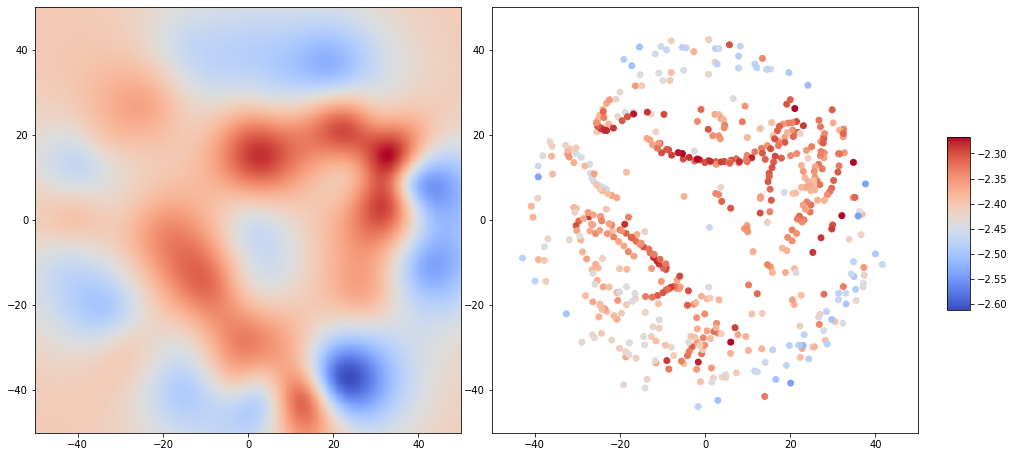

In [8]:
x_exploratory, y_exploratory, z_exploratory, x, y, gp, vmax, vmin = \
                                           plot_bo_estimated_space(kappa, BadIter,
                                              optimizer, pbounds, 
                                              ModelEmbedding, PredictedAcc, 
                                              kernel, output_path, ClassOrRegression)

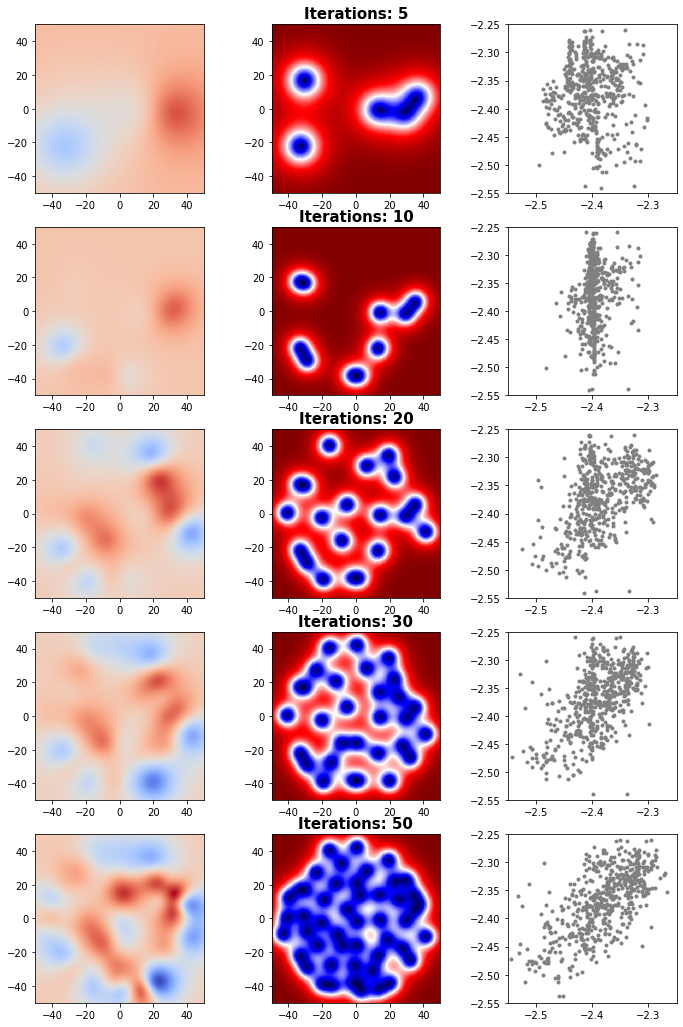

In [18]:
# Display the results of the active search and the evolution of the search
# after 5, 10,20, 30 and 50 iterations.
corr = plot_bo_evolution(kappa, x_exploratory, y_exploratory, z_exploratory, x, y, gp,
                  vmax, vmin, ModelEmbedding, PredictedAcc, output_path, ClassOrRegression)

In [ ]:
print(f'Spearman correlation {corr}')

## Exploitatory analysis

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
kappa = .1

# Define settins for the analysis
kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
                      initialize_bo(ModelEmbedding, kappa)

# Perform optimization. Given that the space is continuous and the analysis 
# approaches are not, we penalize suggestions that are far from any actual 
# analysis approaches. For these suggestions the registered value is set to the
#  lowest value from the burn in. These points (BadIters) are only used
# during search but exluded when recalculating the GP regression after search.
BadIter = run_bo(optimizer, utility, init_points,
                 n_iter, pbounds, nbrs, RandomSeed,
                 ModelEmbedding, model_config, 
                 AgesPrediction,
                 ClassOrRegression,
                 MultivariateUnivariate=True, verbose=False)


 83%|█████████████████████████████████████████████████████▎          | 50/60 [12:10<02:26, 14.61s/it]


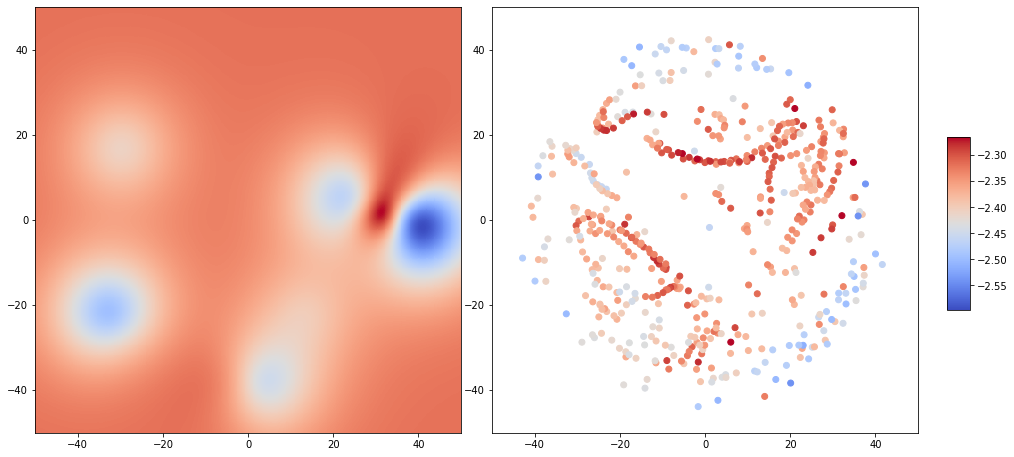

In [28]:
x_exploratory, y_exploratory, z_exploratory, x, y, gp, vmax, vmin = \
                                           plot_bo_estimated_space(kappa, BadIter,
                                              optimizer, pbounds, 
                                              ModelEmbedding, PredictedAcc, 
                                              kernel, output_path, ClassOrRegression)

SpearmanrResult(correlation=0.1702015247783943, pvalue=6.613929487162028e-05)

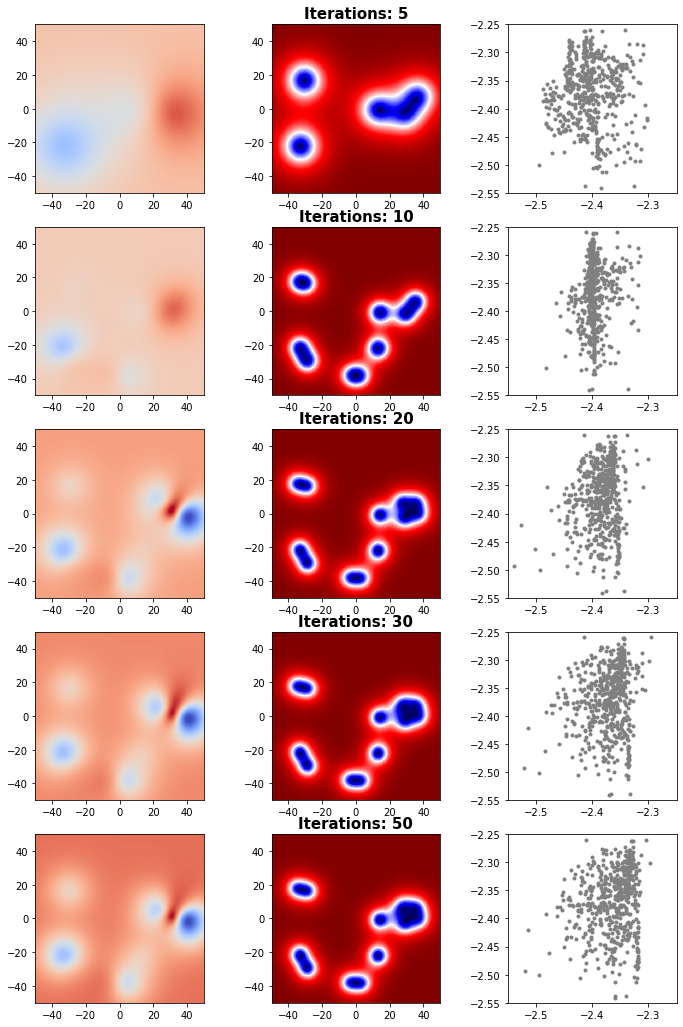

In [29]:
# Display the results of the active search and the evolution of the search
# after 5, 10,20, 30 and 50 iterations.
plot_bo_evolution(kappa, x_exploratory, y_exploratory, z_exploratory, x, y, gp,
                  vmax, vmin, ModelEmbedding, PredictedAcc, output_path, ClassOrRegression)

In [ ]:
# Download file to computer
from google.colab import files
files.download(str(output_path / 'BOptEvolutionK10.svg'))
files.download(str(output_path / 'BOptEvolutionK0.1.svg'))
files.download(str(output_path / 'BOptAndTrueK0.1.svg'))
files.download(str(output_path / 'BOptAndTrueK10.svg'))

## Repetitions

This is time consuming step and will take about 4 hrs to run.

In [30]:
n_repetitions = 20
kappa = 10
TotalRegions = 346

BestModelGPSpace = np.zeros(n_repetitions)
BestModelGPSpaceModIndex = np.zeros(n_repetitions)
BestModelEmpirical = np.zeros(n_repetitions)
BestModelEmpiricalModIndex = np.zeros(n_repetitions)
ModelActualAccuracyCorrelation = np.zeros(n_repetitions)
CVPValBestModels = np.zeros(n_repetitions)
cv_mae = np.zeros(n_repetitions)

for DiffInit in range(n_repetitions):
    # Define settings for the analysis
    kernel, optimizer, utility, init_points, n_iter, pbounds, nbrs, RandomSeed = \
                      initialize_bo(ModelEmbedding, kappa, repetitions=True,
                                    DiffInit=DiffInit)
    
    FailedIters = run_bo(optimizer, utility, init_points,
                         n_iter, pbounds, nbrs, RandomSeed,
                         ModelEmbedding, model_config, 
                         AgesPrediction,
                         ClassOrRegression,
                         MultivariateUnivariate=True, verbose=False)
    
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                                  n_restarts_optimizer=10)

    x_temp = np.array([[res["params"]["b1"]] for res in optimizer.res])
    y_temp = np.array([[res["params"]["b2"]] for res in optimizer.res])
    z_temp = np.array([res["target"] for res in optimizer.res])

    x_obs=x_temp[FailedIters==0]
    y_obs=y_temp[FailedIters==0]
    z_obs=z_temp[FailedIters==0]
    
    muModEmb,sigmaModEmb,gpModEmb=posteriorOnlyModels(gp, x_obs, y_obs, z_obs,
                                                      ModelEmbedding)
    
    BestModelGPSpace[DiffInit] = muModEmb.max()
    BestModelGPSpaceModIndex[DiffInit] = muModEmb.argmax()
    BestModelEmpirical[DiffInit] = z_obs.max()
    Model_coord = np.array([[x_obs[z_obs.argmax()][-1], y_obs[z_obs.argmax()][-1]]])
    BestModelEmpiricalModIndex[DiffInit] = nbrs.kneighbors(Model_coord)[1][0][0]
    ModelActualAccuracyCorrelation[DiffInit] = spearmanr(muModEmb,PredictedAcc)[0]
    
    TempModelNum = muModEmb.argmax()
    Y = AgesPrediction
    CommunityIDs = KeptYeoIDs
    if Data_Run[TempModelNum] == 'MRS':
        TempData=MainNoNanPrediction 
        TotalSubjects=TempData.shape[2]
    elif Data_Run[TempModelNum] == 'GRS':
        TempData = GSRNoNanPrediction
        TotalSubjects = TempData.shape[2]   
    
    TempThreshold = Sparsities_Run[TempModelNum]
    BCT_Num = BCT_Run[TempModelNum]
    
    TempResults=np.zeros([TotalSubjects, n_regions])
    for SubNum in range(0, TotalSubjects):
        x = bct.threshold_proportional(TempData[:, :, SubNum],
                                       TempThreshold, copy=True)
        ss = analysis_space(BCT_Num, BCT_models, x, KeptYeoIDs)
        TempResults[SubNum,:] = ss 
  
    model = Pipeline([('scaler', StandardScaler()), ('svr', SVR(C=1.0, epsilon=0.2))])
    mae, _, p_val = permutation_test_score(model, TempResults, AgesPrediction.ravel(),
                                     groups=None, cv=None, n_permutations=5000, 
                                     n_jobs=None, random_state=5, verbose=0,
                                     scoring="neg_mean_absolute_error")
    CVPValBestModels[DiffInit] = p_val
    cv_mae[DiffInit] = mae
    

 67%|██████████████████████████████████████████▋                     | 20/30 [08:54<04:27, 26.72s/it]


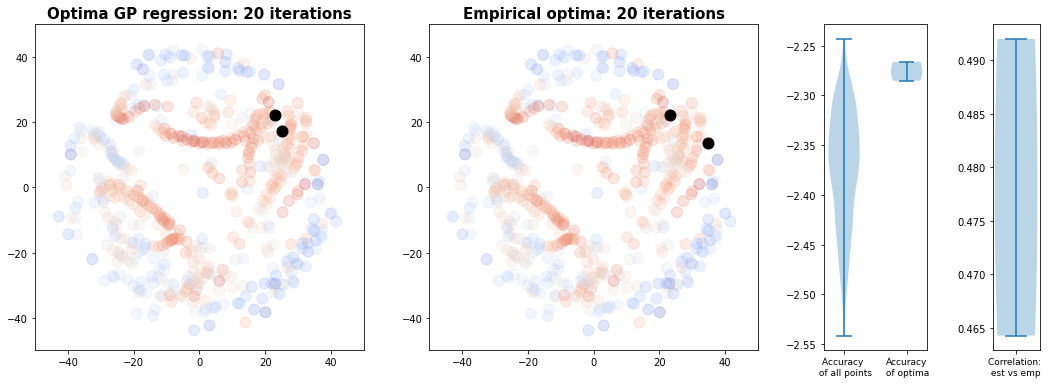

In [31]:
plot_bo_repetions(ModelEmbedding, PredictedAcc, BestModelGPSpaceModIndex,
                  BestModelEmpiricalModIndex, BestModelEmpirical,
                  ModelActualAccuracyCorrelation, output_path, ClassOrRegression)

In [ ]:
# Download image to computer
from google.colab import files
files.download(str(output_path / 'BOpt20Repeats.svg'))

In [ ]:
import pandas as pd
# Obtain the list of 20 models that were defined as the best models
df = pd.DataFrame({'Data_Run': Data_Run,'sparsities': Sparsities_Run, 
                   'bct': BCT_Run})
df_best = df.iloc[BestModelEmpiricalModIndex]
df_best['mae']= cv_mae 

In [ ]:
repetions_results = {
                      'dataframe': df_best,
                      'BestModelGPSpaceModIndex': BestModelGPSpaceModIndex,
                      'BestModelEmpiricalIndex':  BestModelEmpiricalModIndex, 
                      'BestModelEmpirical': BestModelEmpirical,
                      'ModelActualAccuracyCorrelation': ModelActualAccuracyCorrelation
                     }
            pickle.dump( repetions_results, open(str(output_path / "repetitions_results.p"), "wb" ) )

In [ ]:
print(df_best.to_latex(index=False))

In [ ]:
from google.colab import files
files.download(str(output_path / 'repetitions_results.p'))